In [3]:
import os
import pandas as pd

# ============================================================
# 路徑設定
# ============================================================
BASE_DIR = "../preprocessed_data/CAGE-merged"
FEATURE_DIR = os.path.join(BASE_DIR, "3. add features engineer")
BED_DIR = os.path.join(BASE_DIR, "5. bed features")
OUTPUT_DIR = os.path.join(BASE_DIR, "6. merged_with_bed")
os.makedirs(OUTPUT_DIR, exist_ok=True)

CELLS = ["X1", "X2", "X3"]

# ============================================================
# 小工具：確保 gene_name 唯一並一致
# ============================================================
def preprocess_gene_col(df):
    if "gene_name" not in df.columns:
        raise ValueError("❌ Missing 'gene_name' column in one of the files.")
    df["gene_name"] = df["gene_name"].astype(str)
    return df.drop_duplicates(subset=["gene_name"], keep="first").reset_index(drop=True)

# ============================================================
# 主迴圈：自動跑 X1, X2, X3
# ============================================================
for cell in CELLS:
    print(f"\n=== 🧬 Processing {cell} ===")

    train_path = os.path.join(FEATURE_DIR, f"{cell}_all_rank_features.tsv")
    bed_path = os.path.join(BED_DIR, f"{cell}_with_allMarks.tsv")
    output_path = os.path.join(OUTPUT_DIR, f"{cell}_all_features_with_bed.tsv")

    # --- 檢查檔案存在 ---
    if not os.path.exists(train_path):
        print(f"⚠️ Skip {cell}: missing feature file {train_path}")
        continue
    if not os.path.exists(bed_path):
        print(f"⚠️ Skip {cell}: missing bed feature file {bed_path}")
        continue

    # --- 讀取 ---
    print("📖 Loading main feature table ...")
    df_main = pd.read_csv(train_path, sep="\t")
    print("📖 Loading bed-derived feature table ...")
    df_bed = pd.read_csv(bed_path, sep="\t")

    # --- 預處理 ---
    df_main = preprocess_gene_col(df_main)
    df_bed = preprocess_gene_col(df_bed)

    # --- 合併 ---
    print(f"🔗 Merging {cell} features ...")
    df_merged = df_main.merge(df_bed, on="gene_name", how="left", suffixes=("", "_bed"))
    df_merged = df_merged.fillna(0.0)

    # --- 儲存 ---
    df_merged.to_csv(output_path, sep="\t", index=False)
    print(f"✅ Saved merged dataset for {cell} → {output_path} ({df_merged.shape})")

print("\n🎉 All cell lines processed successfully!")



=== 🧬 Processing X1 ===
📖 Loading main feature table ...
📖 Loading bed-derived feature table ...
🔗 Merging X1 features ...
✅ Saved merged dataset for X1 → ../preprocessed_data/CAGE-merged/6. merged_with_bed/X1_all_features_with_bed.tsv ((16284, 745))

=== 🧬 Processing X2 ===
📖 Loading main feature table ...
📖 Loading bed-derived feature table ...
🔗 Merging X2 features ...
✅ Saved merged dataset for X2 → ../preprocessed_data/CAGE-merged/6. merged_with_bed/X2_all_features_with_bed.tsv ((16284, 745))

=== 🧬 Processing X3 ===
📖 Loading main feature table ...
📖 Loading bed-derived feature table ...
🔗 Merging X3 features ...
✅ Saved merged dataset for X3 → ../preprocessed_data/CAGE-merged/6. merged_with_bed/X3_all_features_with_bed.tsv ((1984, 745))

🎉 All cell lines processed successfully!


In [20]:
import os
import json
import random
import pickle   # ✅ 新增
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr
from datetime import datetime

# ============================================================
#                  GLOBAL REPRODUCIBILITY
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"🔒 Global seed set to {SEED}")

# ============================================================
#                  EXPERIMENT CONFIGURATION
# ============================================================
EXPERIMENT_DIR = "../results/lgbm/model_setting/best/with_bed_1&2&3"
TRAIN_PATH = "../preprocessed_data/CAGE-merged/6. merged_with_bed/X1_all_features_with_bed.tsv"
VAL_PATH   = "../preprocessed_data/CAGE-merged/6. merged_with_bed/X2_all_features_with_bed.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_COL = "gex_rank"

os.makedirs(EXPERIMENT_DIR, exist_ok=True)
LOG_PATH = os.path.join(EXPERIMENT_DIR, "log.txt")

# ✅ 如果已有舊的 log.txt，直接覆蓋（清空）
with open(LOG_PATH, "w") as f:
    f.write("")  # 或寫入 header，如 "==== New Experiment ====\n"

def log(msg):
    """同時印出並寫入 log.txt"""
    print(msg)
    with open(LOG_PATH, "a") as f:
        f.write(f"{msg}\n")


log(f"🚀 Experiment started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
log(f"Experiment directory: {EXPERIMENT_DIR}")

# ============================================================
#                  DATA LOADING
# ============================================================
df_train_full = pd.read_csv(TRAIN_PATH, sep="\t")
df_val_full   = pd.read_csv(VAL_PATH, sep="\t")

feature_cols = features_pruned
log(f"Feature count: {len(feature_cols)}")

# ============================================================
#                  K-FOLD DEFINITION
# ============================================================
chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]

log("🧩 Chromosome folds:")
for i, fset in enumerate(folds):
    log(f"Fold {i+1}: {fset}")

# ============================================================
#                  LIGHTGBM PARAMETERS
# ============================================================
params = {
        "boosting_type": "gbdt",
        "learning_rate": 0.016676974956976915,
        "num_leaves": 48,
        "max_depth": 8,
        "feature_fraction": 0.64561553423692,
        "bagging_fraction": 0.8113835038425429,
        "bagging_freq": 6,
        "lambda_l1": 0.3316673054635859,
        "lambda_l2": 0.8969317795206216,
        "min_gain_to_split": 0.04923442843722911,
        "min_data_in_leaf": 38,
        "verbose": -1,
        "seed": SEED,
    }
# ============================================================
#                  SAVE CONFIG
# ============================================================
config = {
    "train_path": TRAIN_PATH,
    "val_path": VAL_PATH,
    "seed": SEED,
    "params": params,
    "folds": folds,
    "target_col": TARGET_COL,
}
with open(os.path.join(EXPERIMENT_DIR, "config.json"), "w") as f:
    json.dump(config, f, indent=4)

# ============================================================
#                  TRAINING
# ============================================================
results = []
preds_all = []

preds_all = []

for fold_idx, val_chrs in enumerate(folds):
    log(f"\n🚀 Fold {fold_idx+1}/{len(folds)} | Val chromosomes: {val_chrs}")
    fold_dir = os.path.join(EXPERIMENT_DIR, f"fold_{fold_idx+1}")
    os.makedirs(fold_dir, exist_ok=True)

    # Split
    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train = df_train_full[df_train_full["chr"].isin(train_chrs)].copy()
    df_val   = df_val_full[df_val_full["chr"].isin(val_chrs)].copy()

    # ✅ 保留原始 index，方便之後對齊
    df_val = df_val.reset_index().rename(columns={"index": "orig_idx"})

    X_train, y_train = df_train[feature_cols], df_train[TARGET_COL]
    X_val, y_val     = df_val[feature_cols], df_val[TARGET_COL]

    dtrain = lgb.Dataset(X_train, label=y_train)
    dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dval],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    # Save model (.pkl)
    model_path = os.path.join(fold_dir, "model.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(model, f)
    log(f"💾 Model saved: {model_path}")

    # Predict
    df_val["predicted_gex_rank"] = model.predict(X_val, num_iteration=model.best_iteration)
    df_val["fold_id"] = fold_idx + 1  # optional: fold 來源

    preds_all.append(df_val[["orig_idx", "gene_name", "predicted_gex_rank", "fold_id"]])

    # Evaluate
    overall_spearman = spearmanr(df_val[TARGET_COL], df_val["predicted_gex_rank"])[0]
    log(f"📈 Fold {fold_idx+1} Overall Spearman ρ = {overall_spearman:.4f}")
    log("📊 Per-Chromosome Spearman:")
    chr_corrs = []
    for chrom, subdf in df_val.groupby("chr"):
        if len(subdf) < 2:
            continue
        rho = spearmanr(subdf[TARGET_COL], subdf["predicted_gex_rank"])[0]
        chr_corrs.append({"chr": chrom, "spearman": rho})
        log(f"   {chrom:<6s}: ρ = {rho:.4f}")

    results.append({
        "fold": fold_idx + 1,
        "val_chr": val_chrs,
        "overall_spearman": overall_spearman,
        "per_chr": chr_corrs
    })

# ============================================================
#                  SAVE PREDICTIONS & SUMMARY
# ============================================================

# ============================================================
# 🔁 合併並依照原始順序還原
# ============================================================
df_preds_all = pd.concat(preds_all, ignore_index=True)
df_preds_all = df_preds_all.sort_values("orig_idx").reset_index(drop=True)

# 驗證對齊
assert len(df_preds_all) == len(df_val_full)
assert (df_preds_all["gene_name"].values == df_val_full["gene_name"].values).all(), \
    "❌ Prediction order mismatch with df_val_full!"

# ✅ 輸出只有 gene_name + predicted_gex_rank
df_preds_all[["gene_name", "predicted_gex_rank"]].to_csv(
    os.path.join(EXPERIMENT_DIR, "predict_val.tsv"), sep="\t", index=False
)
log("💾 Final predictions (aligned) saved (predict_val.tsv)")

# ✅ 全域 Spearman：用原始 df_val_full 的真值 vs 你的預測
overall_val_spearman = spearmanr(
    df_val_full["gex_rank"], 
    df_preds_all["predicted_gex_rank"]
)[0]
log(f"🌍 Overall validation Spearman (aligned) = {overall_val_spearman:.4f}")




summary_fold = pd.DataFrame([
    {"fold": r["fold"], "val_chr": ",".join(r["val_chr"]), "overall_spearman": r["overall_spearman"]}
    for r in results
])

chr_rows = []
for r in results:
    for c in r["per_chr"]:
        chr_rows.append({"fold": r["fold"], "chr": c["chr"], "spearman": c["spearman"]})
summary_chr = pd.DataFrame(chr_rows)

chr_mean = summary_chr.groupby("chr", as_index=False)["spearman"].mean()
chr_mean.rename(columns={"spearman": "mean_spearman"}, inplace=True)

# summary_output = summary_fold.merge(chr_mean, how="cross")
# summary_output.to_csv(os.path.join(EXPERIMENT_DIR, "summary.tsv"), sep="\t", index=False)

# log("💾 Summary saved (summary.tsv)")
log(f"Mean Spearman (across folds): {summary_fold['overall_spearman'].mean():.4f}")
log(f"Overall mean of per-chromosome means: {chr_mean['mean_spearman'].mean():.4f}")

log(f"\n✅ Experiment finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


🔒 Global seed set to 42
🚀 Experiment started at 2025-10-14 18:04:20
Experiment directory: ../results/lgbm/model_setting/best/with_bed_1&2&3
Feature count: 379
🧩 Chromosome folds:
Fold 1: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Fold 2: ['chr3', 'chr8', 'chr13', 'chr18']
Fold 3: ['chr4', 'chr9', 'chr14', 'chr19']
Fold 4: ['chr5', 'chr10', 'chr15', 'chr20']
Fold 5: ['chr6', 'chr11', 'chr16', 'chr21']

🚀 Fold 1/5 | Val chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Training until validation scores don't improve for 100 rounds
[200]	train's l2: 0.0151515	val's l2: 0.0303964
[400]	train's l2: 0.0124842	val's l2: 0.0293474
Early stopping, best iteration is:
[457]	train's l2: 0.012113	val's l2: 0.0292162
💾 Model saved: ../results/lgbm/model_setting/best/with_bed_1&2&3/fold_1/model.pkl
📈 Fold 1 Overall Spearman ρ = 0.7711
📊 Per-Chromosome Spearman:
   chr12 : ρ = 0.7852
   chr17 : ρ = 0.7634
   chr2  : ρ = 0.7668
   chr22 : ρ = 0.7529
   chr7  : ρ = 0.7776

🚀 Fold 2/5 | Val chromo

✅ Loaded X1: shape=(16284, 745)
✅ Loaded X2: shape=(16284, 745)
✅ Loaded X3: shape=(1984, 745)

📊 Total feature count (before pruning): 736
🧩 X1: 334 correlated pairs → 308 features with |r| > 0.95
🧩 X2: 349 correlated pairs → 327 features with |r| > 0.95
🧩 X3: 364 correlated pairs → 323 features with |r| > 0.95

🔗 Union (any cell) high corr features: 357
🔗 Intersection (all cells) high corr features: 284

✅ Remaining features after pruning: 379 (removed 357)
💾 Saved pruned X1 → ../preprocessed_data/CAGE-merged/6. merged_with_bed/X1_all_features_with_bed_pruned.tsv (shape=(16284, 388))
💾 Saved pruned X2 → ../preprocessed_data/CAGE-merged/6. merged_with_bed/X2_all_features_with_bed_pruned.tsv (shape=(16284, 388))
💾 Saved pruned X3 → ../preprocessed_data/CAGE-merged/6. merged_with_bed/X3_all_features_with_bed_pruned.tsv (shape=(1984, 388))

📈 Visualizing correlation matrix for X1 after pruning ...


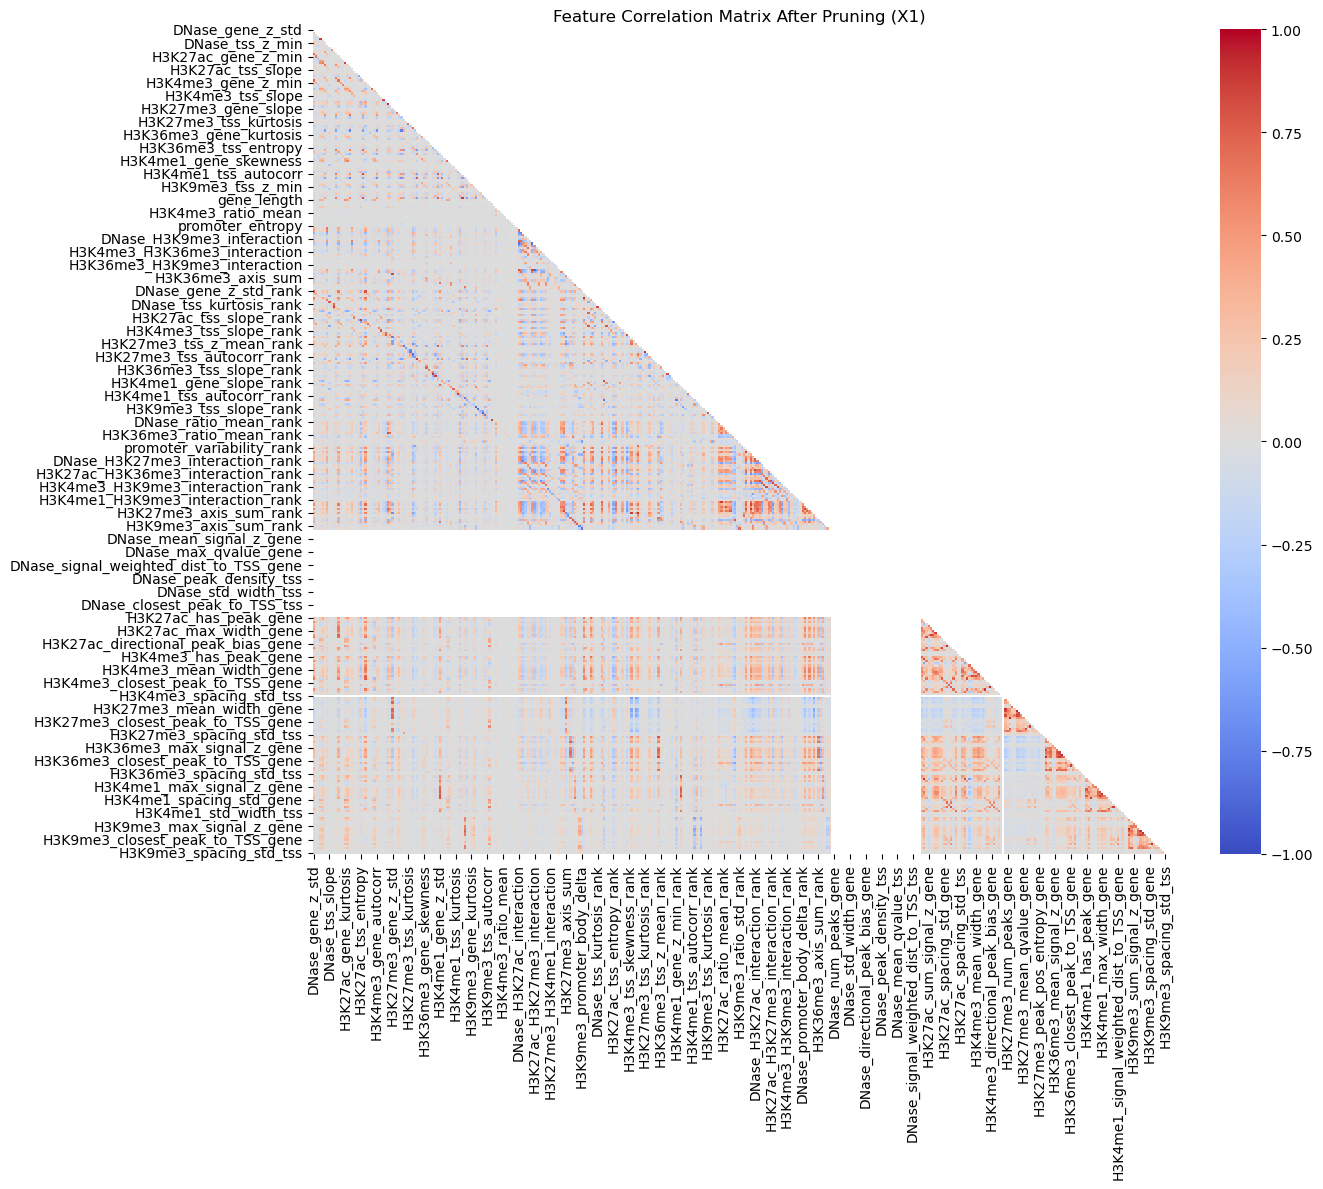

In [19]:

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================================
# CONFIG
# ============================================================
BASE_PATH = "../preprocessed_data/CAGE-merged/6. merged_with_bed"
CELLS = ["X1", "X2", "X3"]

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]

THRESHOLD = 0.95  # 高相關閾值

# ============================================================
# FUNCTION: 找出高相關特徵對
# ============================================================
def get_high_corr_pairs(df, feature_cols, threshold=0.95, method="pearson"):
    X = df[feature_cols]
    corr = X.corr(method=method)
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    pairs = (
        upper.stack()
        .reset_index()
        .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "correlation"})
    )
    pairs = pairs[pairs["correlation"].abs() > threshold]
    return pairs


# ============================================================
# LOAD ALL CELLS
# ============================================================
dfs = {}
for cell in CELLS:
    path = os.path.join(BASE_PATH, f"{cell}_all_features_with_bed.tsv")
    if not os.path.exists(path):
        print(f"⚠️ Missing file: {path}")
        continue
    df = pd.read_csv(path, sep="\t")
    dfs[cell] = df
    print(f"✅ Loaded {cell}: shape={df.shape}")

# 取得 feature columns（假設所有 cell 一致）
feature_cols = [c for c in list(dfs[CELLS[0]].columns) if c not in META_COLS]
print(f"\n📊 Total feature count (before pruning): {len(feature_cols)}")

# ============================================================
# COMPUTE HIGH CORR FEATURES FOR EACH CELL
# ============================================================
high_corr_feats_per_cell = {}

for cell, df in dfs.items():
    pairs = get_high_corr_pairs(df, feature_cols, threshold=THRESHOLD)
    high_corr_feats = set(pairs["feature_1"]) | set(pairs["feature_2"])
    high_corr_feats_per_cell[cell] = high_corr_feats
    print(f"🧩 {cell}: {len(pairs)} correlated pairs → {len(high_corr_feats)} features with |r| > {THRESHOLD}")

# ============================================================
# COMBINE RESULTS ACROSS CELLS
# ============================================================
# --- 取聯集 (任何一個 cell 高相關就移除) ---
union_feats = set().union(*high_corr_feats_per_cell.values())

# --- 取交集 (所有 cell 都高相關才移除) ---
intersection_feats = set.intersection(*high_corr_feats_per_cell.values())

print(f"\n🔗 Union (any cell) high corr features: {len(union_feats)}")
print(f"🔗 Intersection (all cells) high corr features: {len(intersection_feats)}")

# ============================================================
# DROP REDUNDANT FEATURES (use union)
# ============================================================
features_pruned = [f for f in feature_cols if f not in union_feats]
print(f"\n✅ Remaining features after pruning: {len(features_pruned)} (removed {len(union_feats)})")

# ============================================================
# SAVE PRUNED DATASETS
# ============================================================
for cell, df in dfs.items():
    df_pruned = df[META_COLS + features_pruned]
    out_path = os.path.join(BASE_PATH, f"{cell}_all_features_with_bed_pruned.tsv")
    df_pruned.to_csv(out_path, sep="\t", index=False)
    print(f"💾 Saved pruned {cell} → {out_path} (shape={df_pruned.shape})")

# ============================================================
# Optional: 可視化 (以 X1 為例)
# ============================================================
if "X1" in dfs:
    print("\n📈 Visualizing correlation matrix for X1 after pruning ...")
    plt.figure(figsize=(14, 12))
    corr = dfs["X1"][features_pruned].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, vmin=-1, vmax=1)
    plt.title("Feature Correlation Matrix After Pruning (X1)")
    plt.tight_layout()
    plt.show()


✅ Loaded X1: shape=(16284, 745)
✅ Loaded X2: shape=(16284, 745)
✅ Loaded X3: shape=(1984, 745)

📊 Total feature count (before pruning): 736

=== 🧬 Processing X1 per chromosome ===


100%|██████████| 21/21 [00:11<00:00,  1.84it/s]



=== 🧬 Processing X2 per chromosome ===


100%|██████████| 21/21 [00:11<00:00,  1.86it/s]



=== 🧬 Processing X3 per chromosome ===


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]



🔗 Union of high-corr features across all cell × chr: 473
✅ Remaining features after pruning: 263 (removed 473)
💾 Saved pruned X1 → ../preprocessed_data/CAGE-merged/6. merged_with_bed/X1_all_features_with_bed_chrPruned.tsv (shape=(16284, 272))
💾 Saved pruned X2 → ../preprocessed_data/CAGE-merged/6. merged_with_bed/X2_all_features_with_bed_chrPruned.tsv (shape=(16284, 272))
💾 Saved pruned X3 → ../preprocessed_data/CAGE-merged/6. merged_with_bed/X3_all_features_with_bed_chrPruned.tsv (shape=(1984, 272))

📈 Visualizing correlation matrix for X1 after pruning ...


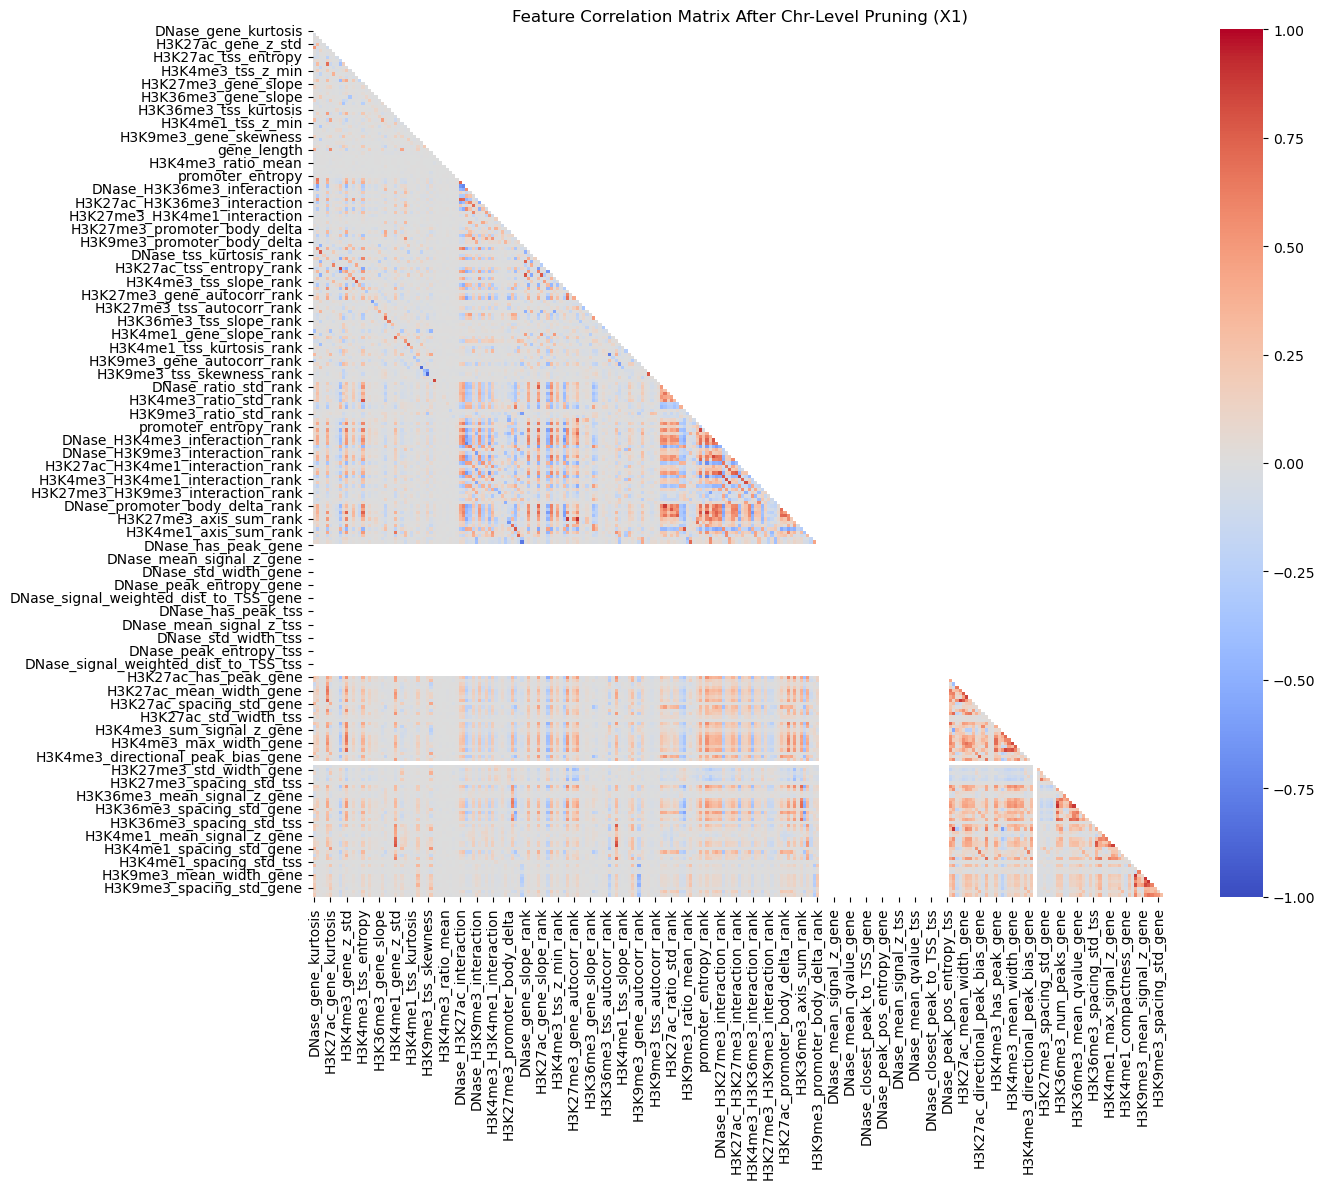

In [15]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# ============================================================
# CONFIG
# ============================================================
BASE_PATH = "../preprocessed_data/CAGE-merged/6. merged_with_bed"
CELLS = ["X1", "X2", "X3"]

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]

THRESHOLD = 0.95  # 高相關閾值

# ============================================================
# FUNCTION: 找出高相關特徵對 (for a subset)
# ============================================================
def get_high_corr_pairs(df, feature_cols, threshold=0.95, method="pearson"):
    """Compute correlated feature pairs within df subset"""
    if len(df) < 5:  # 資料太少就略過
        return set()
    X = df[feature_cols]
    if X.isnull().all(axis=None):
        return set()
    corr = X.corr(method=method)
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    pairs = (
        upper.stack()
        .reset_index()
        .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "correlation"})
    )
    pairs = pairs[pairs["correlation"].abs() > threshold]
    # 將所有出現的 feature 加入 set
    feats = set(pairs["feature_1"]) | set(pairs["feature_2"])
    return feats


# ============================================================
# LOAD ALL CELLS
# ============================================================
dfs = {}
for cell in CELLS:
    path = os.path.join(BASE_PATH, f"{cell}_all_features_with_bed.tsv")
    if not os.path.exists(path):
        print(f"⚠️ Missing file: {path}")
        continue
    df = pd.read_csv(path, sep="\t")
    dfs[cell] = df
    print(f"✅ Loaded {cell}: shape={df.shape}")

# 取得 feature columns（假設所有 cell 一致）
feature_cols = [c for c in list(dfs[CELLS[0]].columns) if c not in META_COLS]
print(f"\n📊 Total feature count (before pruning): {len(feature_cols)}")

# ============================================================
# PER CELL × PER CHR 高相關特徵檢測
# ============================================================
high_corr_union = set()

for cell, df in dfs.items():
    print(f"\n=== 🧬 Processing {cell} per chromosome ===")
    for chr_name, sub_df in tqdm(df.groupby("chr"), total=df["chr"].nunique()):
        feats = get_high_corr_pairs(sub_df, feature_cols, threshold=THRESHOLD)
        if feats:
            high_corr_union.update(feats)

print(f"\n🔗 Union of high-corr features across all cell × chr: {len(high_corr_union)}")

# ============================================================
# PRUNE FEATURES
# ============================================================
features_pruned = [f for f in feature_cols if f not in high_corr_union]
print(f"✅ Remaining features after pruning: {len(features_pruned)} (removed {len(high_corr_union)})")

# ============================================================
# SAVE PRUNED DATASETS
# ============================================================
for cell, df in dfs.items():
    df_pruned = df[META_COLS + features_pruned]
    out_path = os.path.join(BASE_PATH, f"{cell}_all_features_with_bed_chrPruned.tsv")
    df_pruned.to_csv(out_path, sep="\t", index=False)
    print(f"💾 Saved pruned {cell} → {out_path} (shape={df_pruned.shape})")

# ============================================================
# Optional: 可視化 (以 X1 為例)
# ============================================================
if "X1" in dfs:
    print("\n📈 Visualizing correlation matrix for X1 after pruning ...")
    plt.figure(figsize=(14, 12))
    corr = dfs["X1"][features_pruned].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, vmin=-1, vmax=1)
    plt.title("Feature Correlation Matrix After Chr-Level Pruning (X1)")
    plt.tight_layout()
    plt.show()
